In [1]:
%matplotlib inline

# Unsupervised learning part 2: kmeans

The Yellowing Index (YI) we used as "truth" to access our PCA was a visual classification and may contain an operator error.

Because unsupervised learning methods are all about finding patterns in the data, without training a model with labels, we can "ignore" that and check if there are patterns in the data that matches an expected yellowing index.

We saw in our PCA loading plot that the data may be aggregated in clusters. Let's check a pair plot to see if we can find those patterns are in the data.

In [2]:
import pandas as pd

df = pd.read_csv("pellets-visual-classes-rgb.csv", index_col="image").dropna()
df["yellowing index"] = df["yellowing index"].astype(int)

In [3]:
import seaborn as sns

pair = df.drop(["yellowing index", "erosion index"], axis=1)

/home/filipe/micromamba/envs/ML/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


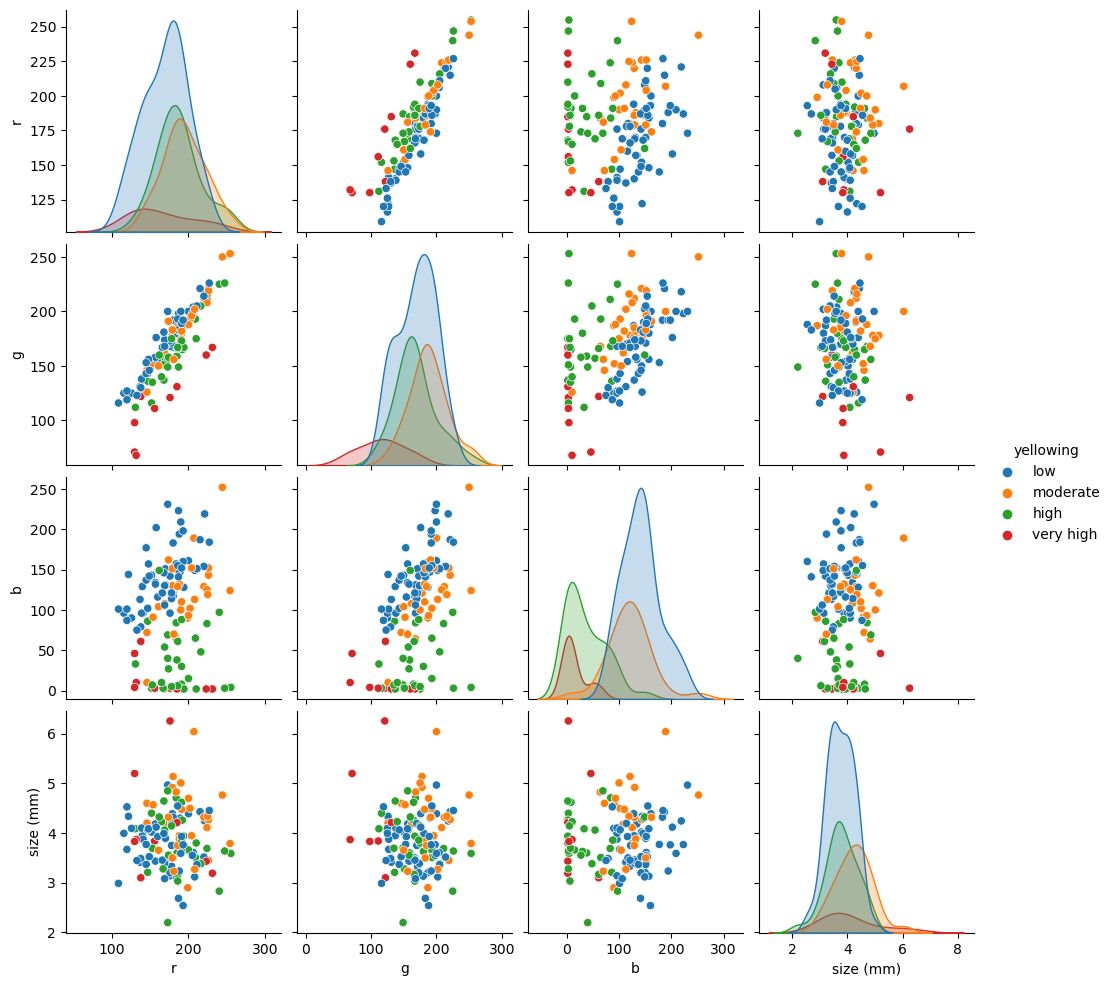

In [4]:
sns.pairplot(pair, hue="yellowing");

From our pair-plot above we can see:
- RGB and size seems to be pretty random, probably no information there;
- R and G seems to be linear correlated with YI;
- R and B, and G and B show some clusterization that may have predictive power on YI.

Let's try the simplest form of clustering ([K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means)). We need to tell it the number of clusters to look (4 YI).

# Features

In [5]:
feature_columns = ["r", "g", "b", "size (mm)"]
X = df[feature_columns].values

In [6]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
cluster_labels = kmeans.predict(X)
cluster_labels

/home/filipe/micromamba/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 3, 2, 0, 3, 3, 3, 0, 1, 3, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 3,
       3, 1, 0, 3, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 2, 1, 0, 1, 0, 1, 2, 3,
       1, 0, 3, 3, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 3, 0, 2, 3, 2,
       0, 3, 3, 3, 0, 0, 3, 0, 3, 2, 0, 0, 3, 0, 1, 1, 2, 1, 1, 1, 2, 0,
       3, 0, 0, 2, 2, 0, 3, 1, 0, 0, 0, 1, 0, 3, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 2, 2, 3, 1, 0, 1, 1, 3, 0, 0, 3, 3, 0, 3, 1, 3], dtype=int32)

In [7]:
redux = df[feature_columns]

/home/filipe/micromamba/envs/ML/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


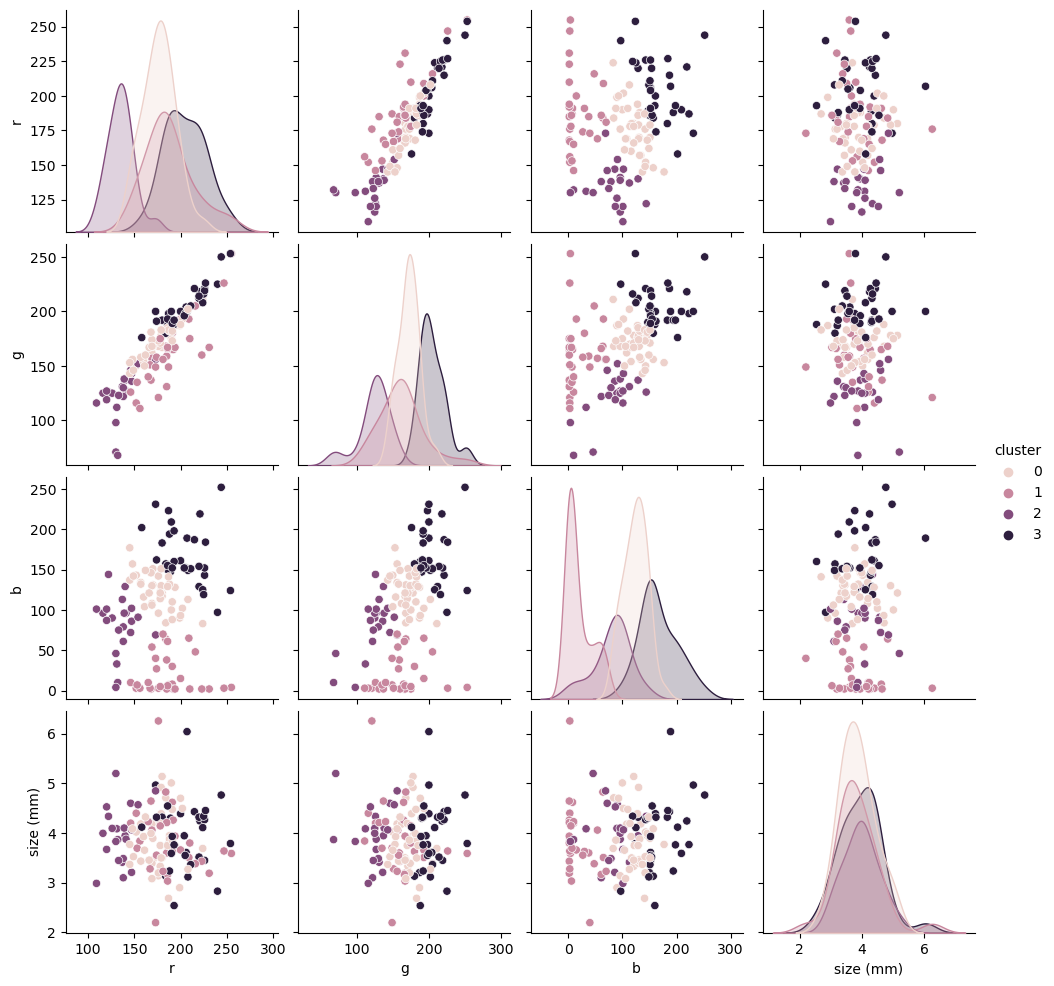

In [8]:
redux = redux.assign(cluster=cluster_labels)
sns.pairplot(redux, hue="cluster");

We do get some nice clustering, even with the size. However, they don't really match our original YI. If you trust the ML 100% one could say that the operator who created our YI was wrong most of the time. We do know better though, so let's try to improve our clustering.

# What are we missing?

In [9]:
redux[feature_columns].mean(axis=0)

r            179.417323
g            169.685039
b            102.031496
size (mm)      3.893000
dtype: float64

In [10]:
redux[feature_columns].std(axis=0)

r            30.910891
g            33.952044
b            61.670777
size (mm)     0.631392
dtype: float64

We did not standardize the data! Instead of rolling our own z-score we can use scikit-learn's own preprocessing module. That will come in handy later when creating data processing pipelines.

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [12]:
X_scaled.mean(axis=0)

array([ 3.14271793e-16,  4.11744130e-16, -1.15393259e-16,  2.79959782e-16])

In [13]:
X_scaled.std(axis=0)

array([1., 1., 1., 1.])

In [14]:
kmeans.fit(X_scaled)

cluster_labels_scaled = kmeans.predict(X_scaled)

/home/filipe/micromamba/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/filipe/micromamba/envs/ML/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


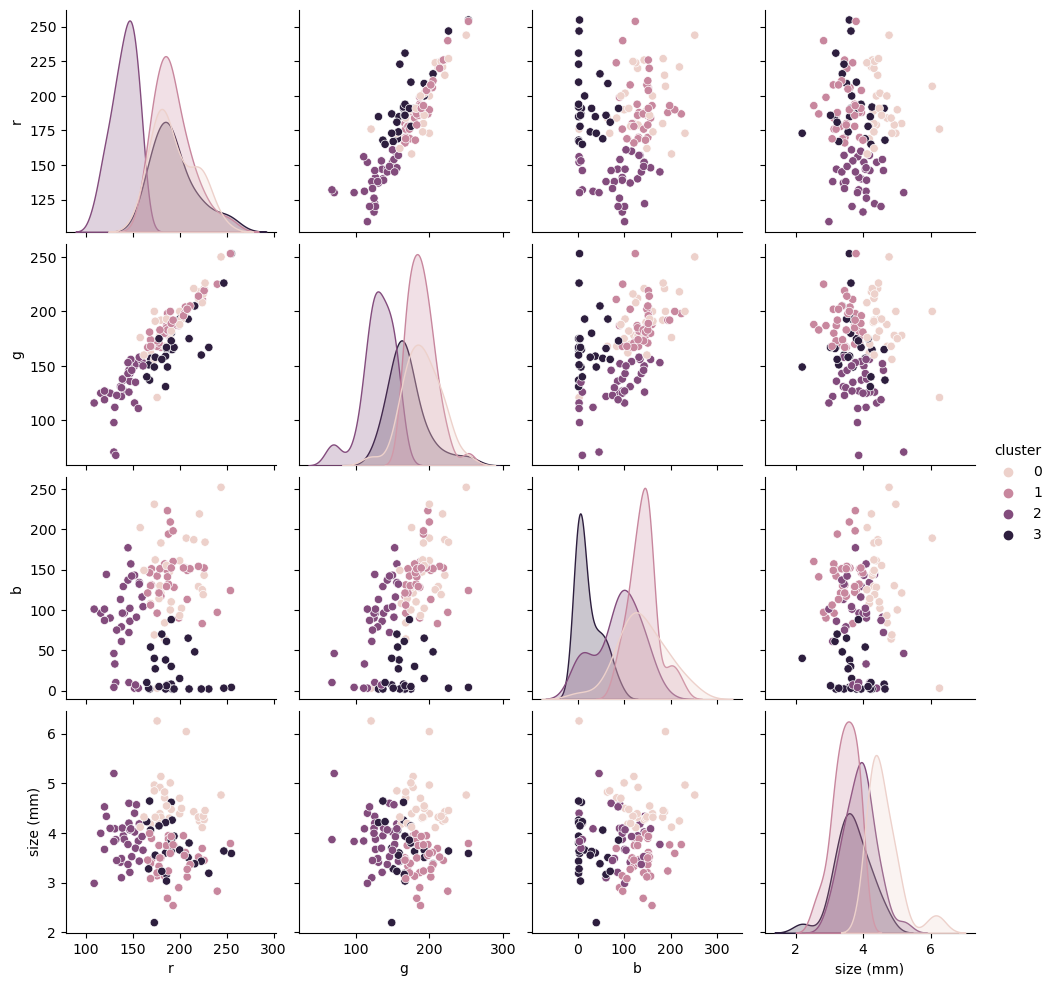

In [15]:
redux = redux.assign(cluster=cluster_labels_scaled)
sns.pairplot(redux, hue="cluster", vars=feature_columns);

While this seems closer to our YI, ignoring the clustering on size b/c originally that was mostly random, it is hard to make visual comparison. Let's trust our YI operator again and compute some metrics on how these clusters compare with the YI.

In [16]:
from sklearn import metrics

y = df["yellowing index"].values
metrics.accuracy_score(y, redux["cluster"])

0.4094488188976378

# ⚠️Negative Results Alert⚠️


- Even if we distrust most of the YI from the human operator this cluster-YI comparison is terrible!
- ML is very helpful but it is not a silver bullet! If you have a Werewolf problem, ML won't help!
- Our features are correlated and there is some overlapping. That may require either a different technique or gather more data from a different feature.

Still, we learned a bit about the data and we should always start with the simplest model and check the results before trying something more complex.


This tutorial was based on the awesome https://github.com/leouieda/ml-intro, which has a nicer result and... Penguins! Check that one out!!